<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/Fine_tunning_BERT_for_kaggle_toxicity_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the data from Kaggle

We are going to be using the data from the Kaggle [Jigsaw Toxic Comments competition](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data). This is a sentiment analysis variation with multiple output classes (not a binary problem). For that, we need to install the kaggle python library and use the API to get access to the data in the Google Colab environment.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
# run this command and upload my Kaggle credentials file:
# files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                     COVID-19 Dataset                                     5MB  2022-11-13 15:47:17          16737        471  1.0              
devrimtuner/list-of-moststreamed-songs-on-spotify             Top 100 Spotify Songs👑🎤🎧🎼                            3KB  2022-12-30 05:42:54            891         44  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india  Credit Card Spending Habits in India               319KB  2022-12-14 07:30:37           2293         68  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset            Fifa World Cu

In [ ]:
! kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

100% 723M/723M [00:34<00:00, 24.3MB/s]
100% 723M/723M [00:34<00:00, 22.1MB/s]


In [ ]:
! unzip /content/jigsaw-unintended-bias-in-toxicity-classification.zip

Archive:  /content/jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: all_data.csv            
  inflating: identity_individual_annotations.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_private_expanded.csv  
  inflating: test_public_expanded.csv  
  inflating: toxicity_individual_annotations.csv  
  inflating: train.csv               


Now the data is available in the current folder in the machine that we are using.

# General imports and importing the data

In [ ]:
! pip install transformers
! pip install datasets
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import transformers
import datasets
import pprint
import torch
import torchinfo


In [ ]:
df = pd.read_csv('train.csv')
df = df[['comment_text', 'target']]

df_sample = (
    pd.concat([
        df[df['target'] >= 0.5].sample(50000, random_state=101),
        df[df['target'] < 0.5].sample(50000, random_state=101)
    ])
)

# for some reason HF only takes the target if it's named "labels".
# So we have to rename the columns:
df_sample = df_sample.rename(columns={'target': 'label', 'comment_text': 'sentence'})
df_sample.head()

,sentence,label
552743,As the racist and idiotic comments posted here...,0.810345
191355,I wonder how much Mark Wiggin knows about HYDR...,0.600000
1721782,"Agreed. This is more useless, politically-corr...",0.600000
1053073,"Yup, 'silly' is right.",0.600000
336458,Academia can and should be a place where some ...,0.700000


This is a notoriously imbalanced dataset, let's check out the distribution of the "target" column to verify what the values are. First thing we notice is that the target is a number, similar to a probability, between zero and one. So we are going to have to deal with that.

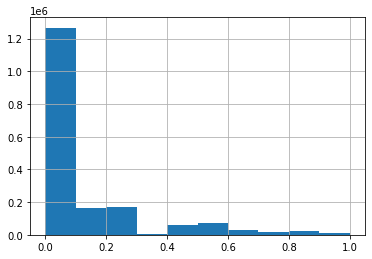

In [ ]:
df['target'].hist()

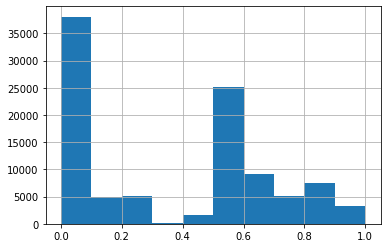

In [ ]:
df_sample['label'].hist()

In [ ]:
df_sample['binary'] = (df_sample['label'] >= 0.5).astype(int)
df_sample['binary'].value_counts()

1    50000
0    50000
Name: binary, dtype: int64

In [ ]:
# Run this line if you want to train a classificaction problem
df_sample = df_sample[['sentence', 'binary']]
df_sample.rename(columns={'binary': 'label'}, inplace=True) # Use this because the HuggingFace trainer needs a column named "target"
df_sample.columns

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Index(['sentence', 'label'], dtype='object')

# Creating a HF Dataset:

Now, let's save the "new" reduced dataset as a csv that we can quickly access. This way, we can use the load_dataset function from the datasets library to import the process as a Dataset.

In [ ]:
# df.to_csv('jigsaw_toxic_comments_clean.csv', index=False)
df_sample.to_csv('jigsaw_toxic_comments_clean_100K_sample.csv', index=False)

In [ ]:
import gc

del df, df_sample
gc.collect()

37

We re-import the data but now as a HuggingFace DatasetDict. This object is similar to a dictionary and it contains all the data in a single key called "train" by default.

**Note:** This is not a train/test split gone wrong, this is simply that the load_dataset function simply assigns all the data to a initial key called "train". We will have to deal with train/test split later.

In [ ]:
# raw_data = datasets.load_dataset("csv", data_files='jigsaw_toxic_comments_clean.csv')
raw_data = datasets.load_dataset("csv", data_files='jigsaw_toxic_comments_clean_100K_sample.csv')
raw_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-759bce9a9b275c12/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 100000
    })
})

## Note about the load_dataset function:

The load_dataset function can also work with:


*   Multi-csv files by passing a list of paths to the "data_files" argument
*   Already-split data by passing a dictionary with "train"/"test" as keys and the values being a list of paths where those files are.

```python
# Multiple CSVs:
datasets.load_dataset('csv', data_files=['train1.csv', 'train2.csv'])

# Already train-test split:
datasets.load_dataset('csv', data_files={'train': ['train1.csv', 'train2.csv'], 'test': ['path/test.csv', 'path/other_test.csv']})

```

In [ ]:
split = raw_data['train'].train_test_split(test_size=0.3, seed=101)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 30000
    })
})

In [ ]:
split['train'][0:3]

{'sentence': ['+++ "Ukrainians are not Russians" +++\nTry telling that to the moron congressional democrats Frick & Frack -- Adam Schiff and Mark Warner -- excuse my speech, a girl bit my tongue when I was 13 -- and the leftist imbeciles at CNN and MSNBC. \nFrom day one they\'ve been saying \'Russians\' when the contacts were Ukrainians.',
  'If division, crisis and factionalism are part of the ANC’s DNA, then this DNA has been genetic corrupted resulting in the sad fact that the ANC is now predominantly criminal and corrupt.',
  "Diverdave,  you have access to the same historic data as I have.  You too lazy to look it up.  Tons of historic fact on the internet.  But I suspect, you won't believe anything contrary to your own, unfounded historic bull!  Afraid to learn the truth?  Why don't you quote me your truths and tell me who said/wrote it?  Put up or shut up!"],
 'label': [1, 1, 0]}

# Setting up the Tokenizer

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenized_examples = tokenizer(split['train'][0:2]['sentence'])

pprint.pprint(tokenized_examples)

## Building the tokenize auxiliary function

This function aids us in applying the tokenizer function to each element in the dataset. The process is built so that the function is applyed batch-by-batch. The way HuggingFace sets up the fine-tuning process is such that we don't need to pad the data, simply apply the truncation.

We use the map method to pass the function through all the dataset. Bear in mind that the dataset contains a lot of long-format text. This means that it may take a while for the tokenize_function to finish.

In [ ]:
def tokenize_function(batch, tokenizer):
  return tokenizer(batch['sentence'], truncation=True)

In [ ]:
tokenized_dataset = split.map(lambda x: tokenize_function(x, tokenizer=tokenizer), batched=True)

  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
})

Next, we create the Training Arguments object. This Training Arguments will be passed to the model during training and they provide an easy way to have a saving and evaluation strategy.

Selecting an "epoch" evaluation strategy makes it so that the metric is evaluated each time all the elements in the training data pass through the model once (epoch).

Selecting an "epoch" saving strategy makes it so that the model is saved after every "epoch". By default, the model is saved after each batch. This is too much!

Finally, we are going to be testing 3 epochs and seeing if the model overfits. If it doesn't we may need more epochs.

In [ ]:
training_arguments = transformers.TrainingArguments(
    "distilbert_on_jigsaw_toxicity", 
    evaluation_strategy='epoch', 
    save_strategy="epoch", 
    num_train_epochs=10
)

# Building the model

We will be importing the BERT pre-trained model parameters loaded from HuggingFace. Notice that we are using 1 label, because we need the output to be a regression-type.

The HuggingFace logs will correctly indicate that the loaded model is imported with a random weight assigned in the last layer, and so it needs to be trained. This is expected as it is what we intend to do.

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
    # num_labels = 1  # Use this if you want to train probabilities
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
for parameter in model.base_model.parameters():
  parameter.requires_grad = False

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880

Let's select the metric using the datasets.load_metric function and save it to the "metric" object. Then we can run the metric.compute() method on a list to check that it correctly calculates the accuracy. Remember that the metric.compute method calls the predictions of the model "predictions", and the true labels of the data as "references".

In [ ]:
metric = datasets.load_metric('roc_auc')

In [ ]:
def compute_metrics(logits_and_labels, metric):
  logits, labels = logits_and_labels
  probabilities = torch.sigmoid(torch.Tensor(logits))
  preds_array  = probabilities.numpy()[:, 1]
  return metric.compute(references=labels, prediction_scores=preds_array)

In [ ]:
# metric.compute(references=[1, 1, 1, 0], prediction_scores=[0.4, 0.6, 1.0, 0.0])

In [ ]:
trainer = transformers.Trainer(
    model, 
    training_arguments, 
    train_dataset=tokenized_dataset['train'], 
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer
    , compute_metrics=lambda x: compute_metrics(x, metric)
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 70000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26250
  Number of trainable parameters = 592130


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.430700,0.440267,0.878701
2,0.467900,0.438791,0.880726
3,0.451600,0.430605,0.882401


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 8
Saving model checkpoint to distilbert_on_jigsaw_toxicity/checkpoint-8750
Configuration saved in distilbert_on_jigsaw_toxicity/checkpoint-8750/config.json
Model weights saved in distilbert_on_jigsaw_toxicity/checkpoint-8750/pytorch_model.bin
tokenizer config file saved in distilbert_on_jigsaw_toxicity/checkpoint-8750/tokenizer_config.json
Special tokens file saved in distilbert_on_jigsaw_toxicity/checkpoint-8750/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequ

TrainOutput(global_step=26250, training_loss=0.4531708507719494, metrics={'train_runtime': 1549.8867, 'train_samples_per_second': 135.494, 'train_steps_per_second': 16.937, 'total_flos': 9018428105971872.0, 'train_loss': 0.4531708507719494, 'epoch': 3.0})

## Saving the model

In [ ]:
import datetime

version = datetime.datetime.today().strftime('%Y-%m-%d-%H')

trainer.save_model("distilbert_model_jigsaw")

In [ ]:
test = pd.read_csv('/content/test.csv')
test.rename(columns={'comment_text': 'sentence'}, inplace=True)
ids = test['id']

test['sentence'].to_csv('jigsaw_toxic_comments_test_set.csv', index=False)

raw_test_data = datasets.load_dataset("csv", data_files='jigsaw_toxic_comments_test_set.csv')
raw_test_data

## Computing Accuracy

The metric for this problem is the **ROC-AUC score**. The actual metric is a weighted ROC-AUC that uses different weights for different types of toxicities (you can learn more at [this link](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation)). The problem is that our model doesn't output the predictions per se, but the logits. To convert them into probabilities we are going to pass these logits through the **sigmoid** function.

Since we know that our model will input data in that format and we will have to run it again for the predictions of the validation and test sets, we are going to create a small pipeline that takes the logits and converts them into simple probabilities, and computes the metric given those probabilities.

In [ ]:
metric = datasets.load_metric('roc_auc')

<ipython-input-28-ba97f22525c7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('roc_auc')


In [ ]:
preds_train      = trainer.predict(tokenized_dataset['train']) # Training set
preds_validation = trainer.predict(tokenized_dataset['test'])  # Validation set

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30000
  Batch size = 8


In [ ]:
preds_train

PredictionOutput(predictions=array([[-0.6514034 ,  0.610902  ],
       [ 0.16210832, -0.17783202],
       [-1.1248817 ,  1.030555  ],
       ...,
       [ 3.025155  , -2.925619  ],
       [-1.0054944 ,  0.9577161 ],
       [ 0.440715  , -0.52221817]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.45354777574539185, 'test_runtime': 351.8449, 'test_samples_per_second': 198.951, 'test_steps_per_second': 24.869})

In [ ]:
preds_tensor = torch.sigmoid(torch.Tensor(preds_train.predictions))
preds_train_array = preds_tensor.numpy()[:, 1]

In [ ]:
labels_train = tokenized_dataset['train']['label']

In [ ]:
metric.compute(references=labels_train, prediction_scores=preds_train_array)

{'roc_auc': 0.869211532543233}

In [ ]:
def compute_auc(hf_predictions, metric) -> dict:
  """Function that takes in a HuggingFace predictions object 
  (PredictionsOutput) and returns the computed metric.

  :param hf_predictions:
  :type hf_predictions:
  :return:
  :rtype:
  """
  logits, labels = hf_predictions.predictions, hf_predictions.label_ids
  preds_tensor = torch.sigmoid(torch.Tensor(logits))
  preds_array  = preds_tensor.numpy()[:, 1]

  return metric.compute(references=labels, prediction_scores=preds_array)

compute_auc(preds_train, metric)

{'roc_auc': 0.869211532543233}

In [ ]:
compute_auc(preds_validation, metric)

{'roc_auc': 0.8708609675055539}

In [ ]:
tokenized_test = raw_test_data.map(lambda x: tokenize_function(x, tokenizer=tokenizer), batched=True)

In [ ]:
tokenized_test

In [ ]:
predictions = trainer.predict(tokenized_test['train'])

In [ ]:
prediction_array = predictions.predictions.flatten()

submission = pd.DataFrame({'id': ids, 'prediction': prediction_array})
submission

In [ ]:
submission.to_csv('jigsaw_submission_fine_tuned_distilbert.csv')